In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shared_utils
from cpb_analysis_scripts import *
from IPython.display import Markdown, display
from matplotlib.ticker import ScalarFormatter
from scipy.stats import zscore

In [2]:
Markdown(summary)


## Summary
This analysis examines the 'cost' of buses for transit agencies across the country. Specifically, to exammine the variation of bus cost for different bus related categories such as propulsion type and size type. 

As of today, data was scraped from these sources:
1. FTA Bus and Low- and No-Emission Grant Awards press release (federally funded, nationwide data)
2. TIRCP project data (state-funded, California only)
3. DGS useage report for all procurements from California agencies purchasing from New Flyer and Portera.

Analyzing the dataset uncovered several nuances. Some projects included additional components besides bus purchases. Installing charging inffrastructure, constructing transit facilities, and other non-bus components were often wrapped into bus purchases. While there were projects that purchased buses exclusivly, some projects did not include any bus purchases at all or did not accurately or describe the propulsion or bus size type. The variety in these projects may contribute to high variances in “cost per bus”.

The dataset was examined for inconsistencies and data was validated to complete the analysis. The final Dataset was filtered for projects that only procured buses.The compiled data was aggregated by agencies and a 'cost per bus' metric was calculated by dividing the total funding received by the total number of buses they procured.
Initial finding uncovered some outliers where a transit agency’s cost per bus figure exceeded 3 standard deviations away from the mean.

Overall:
- **94** projects with bus purchases were analyzed.
- **924,779,074.00** dollars were awarded to agencies for projects including bus purchases.
- **1460.0** total buses are to be purchased.


Propulsion type values varied wildly amongst the datasets and often times did not explicilty specify the propulsion type. Data was validated and grouped as best as possible based on project description or other indications of specific propulsion type.
The following is a summary of propulsion type metrics.
- The most common propulsion type that was proceeded was **"BEB"**.
- The number of zero-emission buses procured (electric, battery-electric and fuel-cell electric) is **51**.
- the number of non-zero emission buses procured (CNG, hybrids, other alternate fuels) is **36**.
     
The following was discovered after removing outliers:
- overall the average awarded dollars per bus is 866,126.89 dollars, with a standard deviation of 570,612.12 dollars. 
- the average awarded dollars per ZEB is 1,078,604.35 dollars, with a standard deviation of 284,155.58 dollars.
- the average awarded dollars per non-ZEB 541,769.17 dollars, with a standard deviation of $309,129.22 dollars.

Below are key charts that summarize the findings.




## All buses (ZEB and non-ZEB) distribution curve.
This chart shows the distribution of all project.


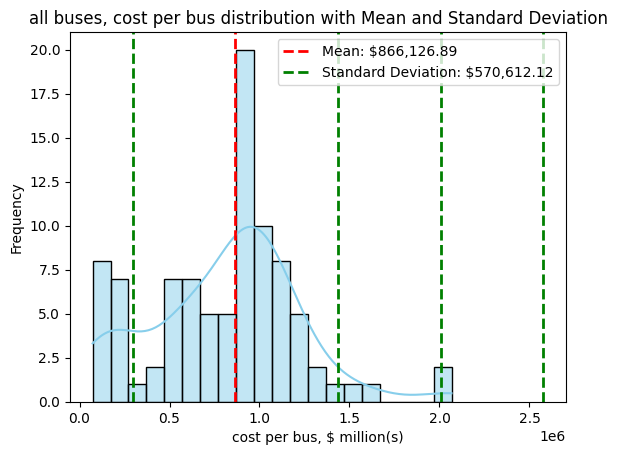

In [3]:
# all bus distribution
display(Markdown(all_bus_desc))

dist_curve(
    df=no_outliers,
    mean=cpb_mean,
    std=cpb_std,
    title="all buses, cost per bus distribution",
    xlabel="cost per bus, $ million(s)",
)

# y axis needs adjusting


## ZEB only  cost/bus Distribution Chart. 
Chart of projects with electric, battery electric, hydrogen fuel cell bus procurements
The majority of the distribution is within +/-1 standard deviation of the mean, however the standard deviation is quite wide at ~$1,200,000.


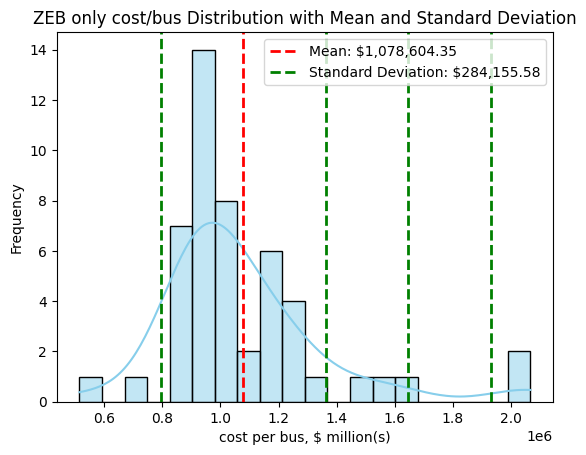

In [4]:
# ZEB dist curve
display(Markdown(zeb_desc))

dist_curve(
    df=zeb_no_outliers,
    mean=zeb_only_mean,
    std=zeb_only_std,
    title="ZEB only cost/bus Distribution",
    xlabel="cost per bus, $ million(s)",
)


## non-ZEB cost/bus Distribution. 
Chart of projects with non-ZEB bus procurement (hybrids, diesel, cng)
This distrubtion is is much more spread out and with a smaller standard deviation.

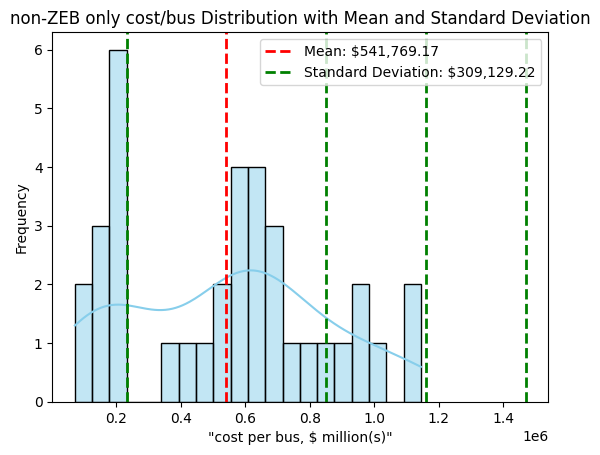

In [5]:
# non_zeb distribution
display(Markdown(non_zeb_desc))

dist_curve(
    non_zeb_no_outliers,
    non_zeb_only_mean,
    non_zeb_only_std,
    title="non-ZEB only cost/bus Distribution",
    xlabel='"cost per bus, $ million(s)"',
)


## Cost per bus by propulsion type. 
The total cost per bus for ZEB categories do fall within a similar range of eachother.

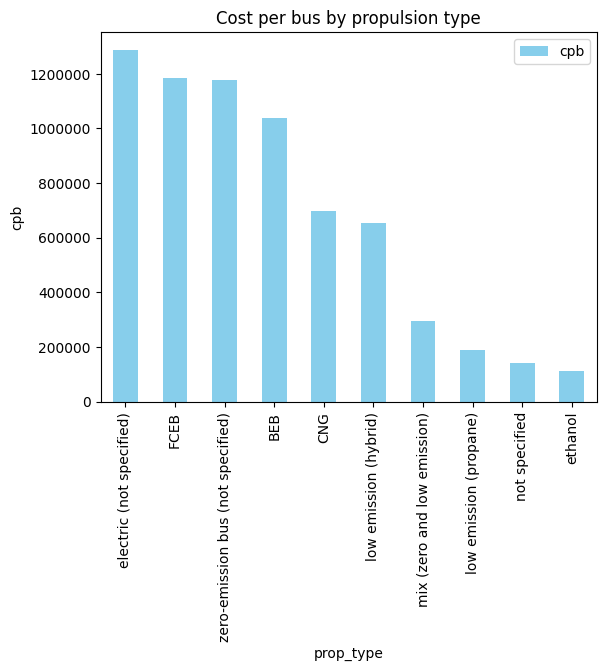

In [6]:
# COST PER BUS BY PROP TYPE
display(Markdown(cpb_prop_type_desc))
make_chart("cpb", "Cost per bus by propulsion type", x_col="prop_type", data=prop_agg)


## Bus count by propulsion type. 
The most common bus type procured were zero-emissions related.

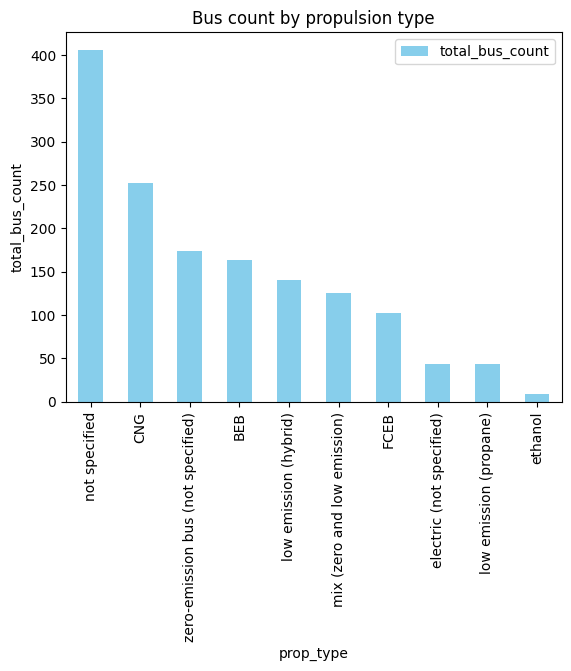

In [7]:
# bus count BY PROP TYPE
display(Markdown(bus_count_prop_type_desc))
make_chart(
    "total_bus_count", 
    "Bus count by propulsion type",
    x_col="prop_type",
    data=prop_agg
)

In [8]:
display(Markdown(conclusion))


## Conclusion
Based on the findings so far, there is data to supports that bus procurement cost vary widely amongst transit agencies all over the country. 
Non-ZEB bus procurement shows wider cost variation. Where as ZEB procurement was much tighter. ZEBs do have a higher cost per bus than non-ZEB, however this may be due to projects that include ZEBs and other bus related expenses.

Lots of project included procuring buses and other components such as charging equipment/stations, new faciliites and other installation/construction activies. The majority of ZEB procurement projects also include the purchase of related charging equipment and infrastructure, indicating that transit agencies are in the early stages of adopting ZEBs and require the initial investment of charging related equipment to operate the buses. Few agencies reported procuring only ZEB buses.

the majority of bus only procurement projects were for non-ZEB bus types.

Futher investigation is needed to isolate projects with only busy procurement. The DGS usage report data is the most granual data and includes itemized cost for bus, options and other configurables.
